In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abszub","key":"72c1a0ef3878b467e2bb825d66a1bc8e"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

kaggle.json
100% 2.29G/2.29G [01:04<00:00, 41.0MB/s]
100% 2.29G/2.29G [01:04<00:00, 38.1MB/s]


In [ ]:
!unzip -q chest-xray-pneumonia.zip -d lol/

In [ ]:
!pip install tensorflow_addons

import pandas as pd       
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import cv2

import warnings
warnings.filterwarnings('ignore')

import random
import os
import glob
from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from tensorflow.random import set_seed
set_seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
test_NORMAL = glob.glob('/content/lol/chest_xray/chest_xray/test/NORMAL/*.jpeg')
test_PNEUMONIA = glob.glob('/content/lol/chest_xray/chest_xray/test/PNEUMONIA/*.jpeg')
train_NORMAL = glob.glob('/content/lol/chest_xray/chest_xray/train/NORMAL/*.jpeg')
train_PNEUMONIA = glob.glob('/content/lol/chest_xray/chest_xray/train/PNEUMONIA/*.jpeg')
val_NORMAL = glob.glob('/content/lol/chest_xray/chest_xray/val/NORMAL/*.jpeg')
val_PNEUMONIA =glob.glob('/content/lol/chest_xray/chest_xray/val/PNEUMONIA/*.jpeg')

print(f"Test normal Set has: {len(test_NORMAL)} images")
print(f"Test penumonia has: {len(test_PNEUMONIA)} images")
print(f"Train normal Set has: {len(train_NORMAL)} images")
print(f"Train pnemonia Set has: {len(train_PNEUMONIA)} images")


Test normal Set has: 234 images
Test penumonia has: 390 images
Train normal Set has: 1341 images
Train pnemonia Set has: 3875 images


In [ ]:
train_list = [x for x in train_NORMAL]
train_list.extend([x for x in train_PNEUMONIA])
df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_NORMAL) , ['Pneumonia']*len(train_PNEUMONIA)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_NORMAL]
test_list.extend([x for x in test_PNEUMONIA])
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_NORMAL) , ['Pneumonia']*len(test_PNEUMONIA)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

val_list = [x for x in val_NORMAL]
val_list.extend([x for x in val_PNEUMONIA])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_NORMAL) , ['Pneumonia']*len(val_PNEUMONIA)]), columns = ['class'])
df_val['image'] = [x for x in val_list]




In [ ]:
df_train

,class,image
0,Normal,/content/lol/chest_xray/chest_xray/train/NORMA...
1,Normal,/content/lol/chest_xray/chest_xray/train/NORMA...
2,Normal,/content/lol/chest_xray/chest_xray/train/NORMA...
3,Normal,/content/lol/chest_xray/chest_xray/train/NORMA...
4,Normal,/content/lol/chest_xray/chest_xray/train/NORMA...
...,...,...
5211,Pneumonia,/content/lol/chest_xray/chest_xray/train/PNEUM...
5212,Pneumonia,/content/lol/chest_xray/chest_xray/train/PNEUM...
5213,Pneumonia,/content/lol/chest_xray/chest_xray/train/PNEUM...
5214,Pneumonia,/content/lol/chest_xray/chest_xray/train/PNEUM...


In [ ]:
df_test

,class,image
0,Normal,/content/lol/chest_xray/chest_xray/test/NORMAL...
1,Normal,/content/lol/chest_xray/chest_xray/test/NORMAL...
2,Normal,/content/lol/chest_xray/chest_xray/test/NORMAL...
3,Normal,/content/lol/chest_xray/chest_xray/test/NORMAL...
4,Normal,/content/lol/chest_xray/chest_xray/test/NORMAL...
...,...,...
619,Pneumonia,/content/lol/chest_xray/chest_xray/test/PNEUMO...
620,Pneumonia,/content/lol/chest_xray/chest_xray/test/PNEUMO...
621,Pneumonia,/content/lol/chest_xray/chest_xray/test/PNEUMO...
622,Pneumonia,/content/lol/chest_xray/chest_xray/test/PNEUMO...


In [ ]:
df_val

,class,image
0,Normal,/content/lol/chest_xray/chest_xray/val/NORMAL/...
1,Normal,/content/lol/chest_xray/chest_xray/val/NORMAL/...
2,Normal,/content/lol/chest_xray/chest_xray/val/NORMAL/...
3,Normal,/content/lol/chest_xray/chest_xray/val/NORMAL/...
4,Normal,/content/lol/chest_xray/chest_xray/val/NORMAL/...
5,Normal,/content/lol/chest_xray/chest_xray/val/NORMAL/...
6,Normal,/content/lol/chest_xray/chest_xray/val/NORMAL/...
7,Normal,/content/lol/chest_xray/chest_xray/val/NORMAL/...
8,Pneumonia,/content/lol/chest_xray/chest_xray/val/PNEUMON...
9,Pneumonia,/content/lol/chest_xray/chest_xray/val/PNEUMON...


In [ ]:
import plotly.graph_objects as go
trace = go.Pie(labels = ['Pneumonia', 'Normal'], values = df_train['class'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of class variable in train dataset')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

Train Set - Normal


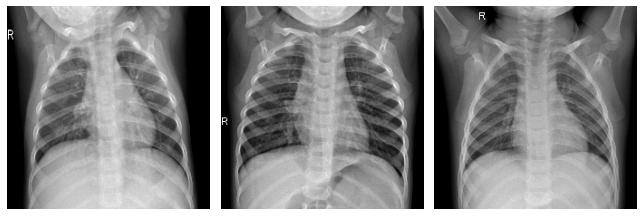

Train Set - Pneumonia


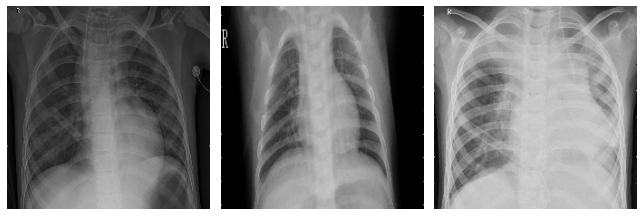

In [ ]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 3):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_NORMAL[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()


print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 3):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_PNEUMONIA[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [ ]:
X, y = train_test_split(df_train, test_size = 0.40 , stratify = df_train['class'])

In [ ]:
#changed target size from (64,64) to (224,224)
train_datasets = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.2,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  rotation_range=20,
                                  shear_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

val_datasets = ImageDataGenerator(rescale=1/255.)

ds_train = train_datasets.flow_from_dataframe(X,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (224, 224),
                                             class_mode = 'binary',
                                             batch_size = 32,
                                            )

ds_val = val_datasets.flow_from_dataframe(y,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = 32,
                                          )

ds_test = val_datasets.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 3129 validated image filenames belonging to 2 classes.
Found 2087 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:
ds_train.class_indices

{'Normal': 0, 'Pneumonia': 1}

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding = 'valid',input_shape=(224,224,3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding = 'valid',activation='relu'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(3,3))
model.add(tf.keras.layers.Dropout(0.2))


model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding = 'valid',activation='relu'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding = 'valid',activation='relu'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,'sigmoid'))
model.add(tf.keras.layers.Activation('relu'))

precision=keras.metrics.Precision()
recall=keras.metrics.Recall()
f1score=F1Score(num_classes=2, threshold=0.5)
optimizer= tf.keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.9, beta_2=0.99999, decay=10e-7)
model.compile(loss = tf.keras.losses.binary_crossentropy,optimizer= tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.99999, decay=10e-7),metrics=['binary_accuracy', precision, recall])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 220, 220, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                        

In [ ]:
history = model.fit(ds_train,epochs=10,validation_data=ds_val,callbacks=[early_stopping,plateau],steps_per_epoch=(len(X)/32),validation_steps=2);

Epoch 1/10
97/97 [==============================] - 96s 882ms/step - loss: 0.5448 - binary_accuracy: 0.7245 - precision: 0.7451 - recall: 0.9566 - val_loss: 0.4343 - val_binary_accuracy: 0.8125 - val_precision: 0.8125 - val_recall: 1.0000 - lr: 3.0000e-04
Epoch 2/10
97/97 [==============================] - 84s 856ms/step - loss: 0.3943 - binary_accuracy: 0.7635 - precision: 0.7730 - recall: 0.9652 - val_loss: 0.3563 - val_binary_accuracy: 0.7656 - val_precision: 0.7619 - val_recall: 1.0000 - lr: 3.0000e-04
Epoch 3/10
97/97 [==============================] - 83s 851ms/step - loss: 0.3584 - binary_accuracy: 0.8150 - precision: 0.8368 - recall: 0.9329 - val_loss: 0.3457 - val_binary_accuracy: 0.8281 - val_precision: 0.8214 - val_recall: 0.9787 - lr: 3.0000e-04
Epoch 4/10
97/97 [==============================] - 83s 846ms/step - loss: 0.3437 - binary_accuracy: 0.8450 - precision: 0.8885 - recall: 0.9049 - val_loss: 0.3689 - val_binary_accuracy: 0.9219 - val_precision: 0.9556 - val_recall: 

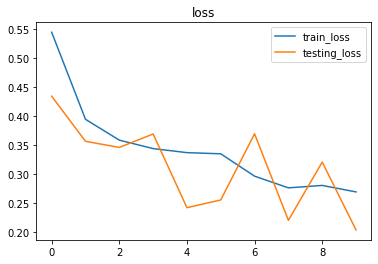

In [ ]:
# plotting the loss
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

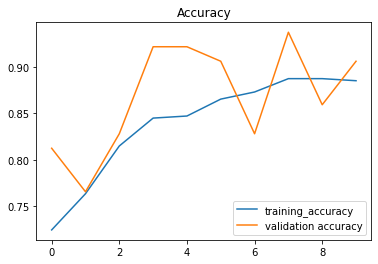

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['binary_accuracy'], label='training_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(ds_val, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2797296941280365
Test accuracy: 0.8797316551208496


In [ ]:
score = model.evaluate(ds_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.36332178115844727
Test accuracy: 0.8669871687889099


  VGG16 MODEL

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [ ]:

vgg = VGG16(input_shape = (224,244,3), weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False
    
flatten = Flatten()(vgg.output)
dense = Dense(200, activation = 'relu')(flatten)
dense = Dense(100, activation = 'relu')(dense)
prediction = Dense(1, activation = 'sigmoid')(dense)

model = Model(inputs = vgg.input, outputs = prediction )

model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 122, 128)     147584    
                                                              

In [ ]:
model.compile(loss = tf.keras.losses.binary_crossentropy,optimizer='adam',metrics=['binary_accuracy', precision, recall])


In [ ]:
history = model.fit(ds_train,validation_data=ds_val,batch_size=24,epochs=10);

Epoch 1/10
98/98 [==============================] - 126s 1s/step - loss: 0.3275 - binary_accuracy: 0.8645 - precision: 0.9083 - recall: 0.9046 - val_loss: 0.2223 - val_binary_accuracy: 0.9123 - val_precision: 0.9928 - val_recall: 0.8884
Epoch 2/10
98/98 [==============================] - 119s 1s/step - loss: 0.1761 - binary_accuracy: 0.9294 - precision: 0.9542 - recall: 0.9505 - val_loss: 0.2027 - val_binary_accuracy: 0.9205 - val_precision: 0.9095 - val_recall: 0.9916
Epoch 3/10
98/98 [==============================] - 124s 1s/step - loss: 0.1683 - binary_accuracy: 0.9310 - precision: 0.9532 - recall: 0.9540 - val_loss: 0.1614 - val_binary_accuracy: 0.9358 - val_precision: 0.9856 - val_recall: 0.9271
Epoch 4/10
98/98 [==============================] - 124s 1s/step - loss: 0.1623 - binary_accuracy: 0.9383 - precision: 0.9615 - recall: 0.9553 - val_loss: 0.2626 - val_binary_accuracy: 0.8975 - val_precision: 1.0000 - val_recall: 0.8619
Epoch 5/10
98/98 [==============================] - 

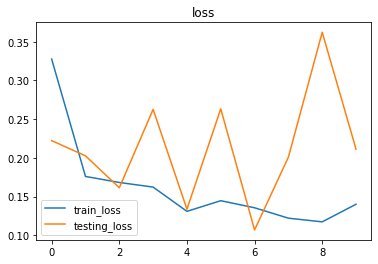

In [ ]:
# plotting the loss
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

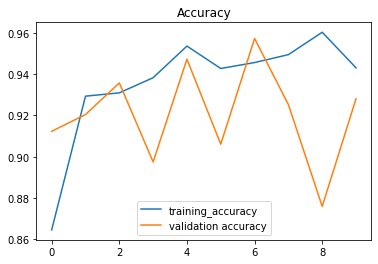

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['binary_accuracy'], label='training_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(ds_val, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21128904819488525
Test accuracy: 0.9281265139579773


In [ ]:
score = model.evaluate(ds_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2594340145587921
Test accuracy: 0.9054487347602844


In [ ]:
preds_vgg = model.predict(ds_test)
y_pred_vgg = np.argmax(preds_vgg, axis =1)

624/624 [==============================] - 12s 20ms/step


In [ ]:
print(classification_report(ds_test.classes, y_pred_vgg))

              precision    recall  f1-score   support

           0       0.38      1.00      0.55       234
           1       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



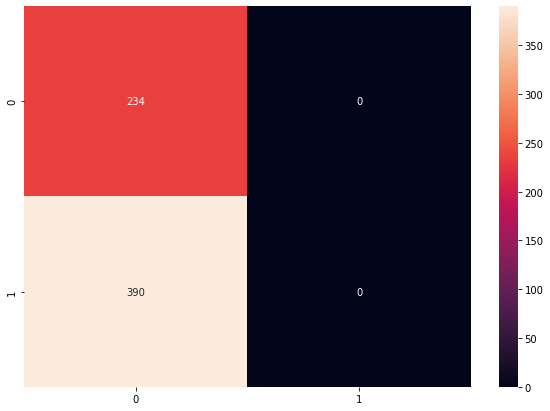

In [ ]:
confusion_matrix_vgg = confusion_matrix(ds_test.classes, y_pred_vgg)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_vgg, annot=True, fmt='g') 
plt.show()

RESNET50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

In [ ]:

model = tf.keras.models.Sequential()
model.add(ResNet50(input_shape=(224,224,3),weights= 'imagenet',include_top=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),padding = 'valid',activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding = 'valid',activation='relu'))
model.add(Flatten())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,'sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 2048)       8192      
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 3, 64)          3276864   
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 1, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                     

In [ ]:
model.compile(loss = tf.keras.losses.binary_crossentropy,optimizer='adam',metrics=['binary_accuracy', precision, recall])

In [ ]:
history = model.fit(ds_train,validation_data=ds_val,batch_size=24,epochs=10);

Epoch 1/10
98/98 [==============================] - 131s 1s/step - loss: 0.4957 - binary_accuracy: 0.8258 - precision: 0.8750 - recall: 0.9072 - val_loss: 6189.5791 - val_binary_accuracy: 0.7427 - val_precision: 0.7427 - val_recall: 1.0000
Epoch 2/10
98/98 [==============================] - 121s 1s/step - loss: 0.3855 - binary_accuracy: 0.8881 - precision: 0.9255 - recall: 0.9239 - val_loss: 3.6383 - val_binary_accuracy: 0.7427 - val_precision: 0.7427 - val_recall: 1.0000
Epoch 3/10
98/98 [==============================] - 121s 1s/step - loss: 0.2323 - binary_accuracy: 0.9064 - precision: 0.9500 - recall: 0.9226 - val_loss: 1.5156 - val_binary_accuracy: 0.7427 - val_precision: 0.7427 - val_recall: 1.0000
Epoch 4/10
98/98 [==============================] - 121s 1s/step - loss: 0.3307 - binary_accuracy: 0.9092 - precision: 0.9578 - recall: 0.9183 - val_loss: 4.3377 - val_binary_accuracy: 0.7427 - val_precision: 0.7427 - val_recall: 1.0000
Epoch 5/10
98/98 [==============================]

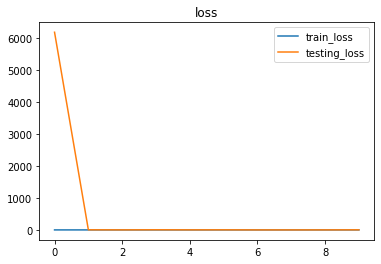

In [ ]:
# plotting the loss
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

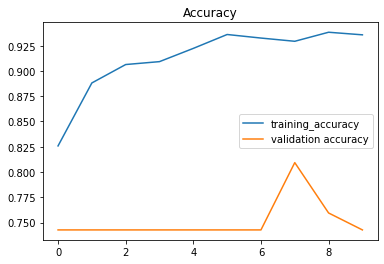

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['binary_accuracy'], label='training_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(ds_val, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.058105707168579
Test accuracy: 0.7426928877830505


In [ ]:
score = model.evaluate(ds_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 5.730964660644531
Test accuracy: 0.625


In [ ]:
preds_resnet = model.predict(ds_test)
y_pred_resnet = np.argmax(preds_vgg, axis =1)

624/624 [==============================] - 15s 22ms/step


In [ ]:
print(classification_report(ds_test.classes, y_pred_resnet))

              precision    recall  f1-score   support

           0       0.38      1.00      0.55       234
           1       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624

